# Python Tutorial on U-Net for Brain Tumor Detection from  MRI Scans using Deep Learning Library

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This tutorial includes the implementation of the deep learning model, U-Net for multi-class semantic segmentation on CAMUS Dataset. The following are the steps involved in this process.
1. Import necessary libraries
2. Prepare data for processing
3. Create the model
4. Compile and train the model
5. Visualization of training loss and accuracy
6. Prediction of results using the model
7. Evaluation of performance of the model

## Step-1. Importing library packages

The packages imported here are TensorFlow dependencies, NumPyand Matplotlib. NumPy is the fundamental package used for working with arrays. Matplotlib is used here to read and display the images.

In [ ]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
import tensorflow.keras as k
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
  # import tensorflow as tf
  # gpus = tf.config.experimental.list_physical_devices('GPU')
  # if gpus:
  #     try:
  #         tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
  #     except RuntimeError as e:
  #         print(e)

In [ ]:
import os
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import cv2

import random
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, activations, metrics
from tensorflow.keras import Input, Model
# import tensorflow_addons as tfa

print(f"La version de Tensorflow es {tf.__version__}. Pueden Diferir algunas funciones!")

La version de Tensorflow es 2.17.0. Pueden Diferir algunas funciones!


In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Step 2. Dataset preparation

https://www.kaggle.com/code/victortrigo/u-net-brian-mri-segmentation/data


In [ ]:
%%time
root = '/content/drive/MyDrive/train/New/'
def get_images_path():
    images = []
    labels = []


    for d in tqdm(os.listdir(root)):
        path = os.path.join(root, d)
        print(d)
        if os.path.isdir(path):
            iters = int(len(os.listdir(path))/2)
            for i in range(iters):
                file = os.path.join(path, d) + '_' +str(i+1) + '.tif'
                mask = os.path.join(path, d) + '_' +str(i+1) + '_mask.tif'
                images.append(file)
                labels.append(mask)
    return images, labels



def read_images(paths, tipefile):
    images = []

    if tipefile == 'images':
        for f in tqdm(paths):
            img = read_image(f)
            images.append(img)

    else:

        for f in tqdm(paths):
            img = read_mask(f)

            images.append(img)

    imgs1 = np.array(images)


    return imgs1
#
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x,(128,128))
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):

    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x,(128,128))
    x = x/255.0
    x = x > 0.5
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 12.4 µs


In [ ]:
images, labels = get_images_path()
images = read_images(images , 'images')
masks = read_images(labels, 'masks')

100%|██████████| 14/14 [00:00<00:00, 549.00it/s]


TCGA_CS_4941_19960909
TCGA_CS_4942_19970222
TCGA_CS_4943_20000902
TCGA_CS_4944_20010208
TCGA_CS_5393_19990606
TCGA_CS_5395_19981004
TCGA_CS_5396_20010302
TCGA_CS_6186_20000601
TCGA_CS_6665_20010817
TCGA_CS_6666_20011109
TCGA_CS_6667_20011105
TCGA_HT_A5RC_19990831
TCGA_HT_A61A_20000127
TCGA_HT_A61B_19991127


100%|██████████| 364/364 [00:02<00:00, 177.82it/s]


In [ ]:
def plot_image(image, mask):
   plt.figure(figsize=(7, 7))

   plt.subplot(1, 2, 1)
   plt.imshow(image)
   plt.title('Image')
   plt.subplot(1, 2, 2)
   plt.imshow(mask)
   plt.title('Mask')



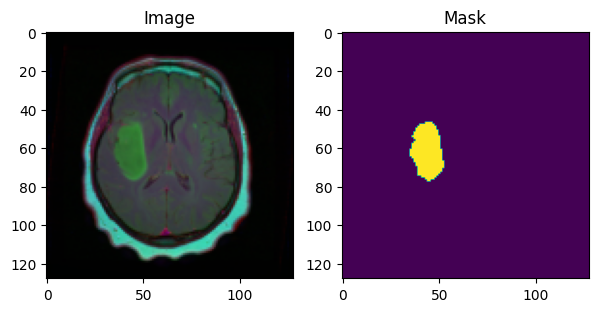

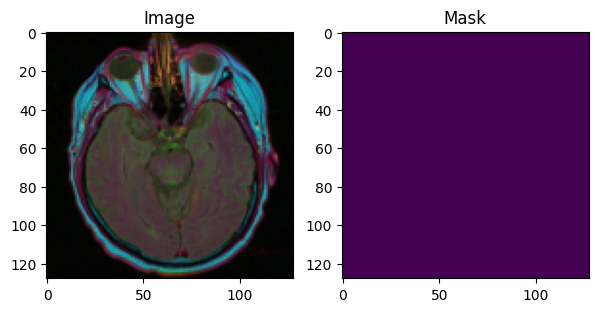

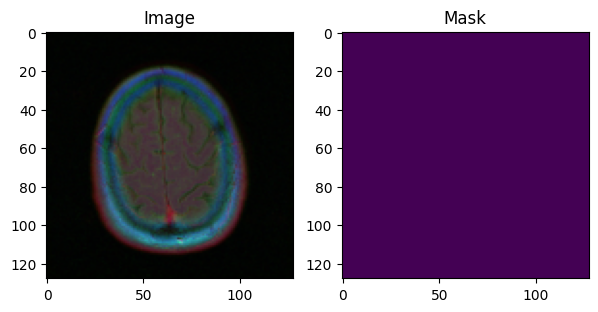

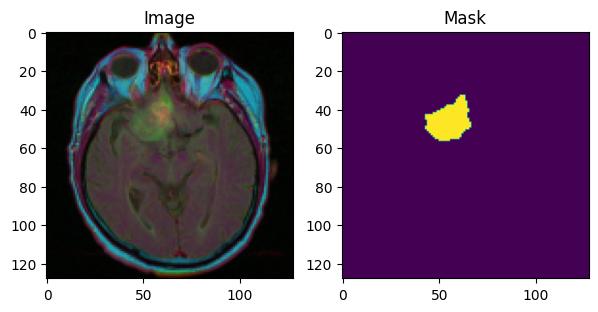

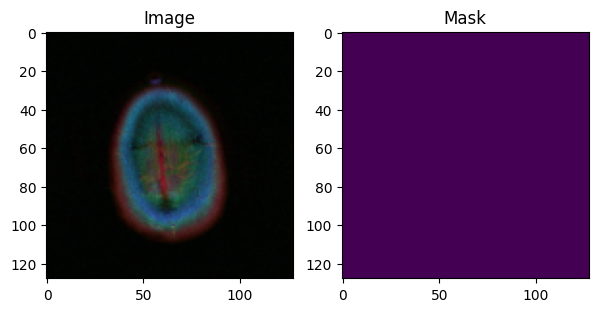

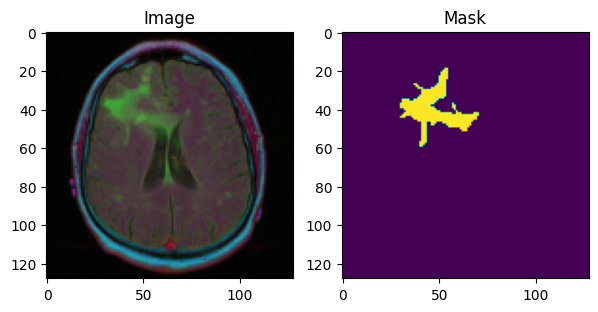

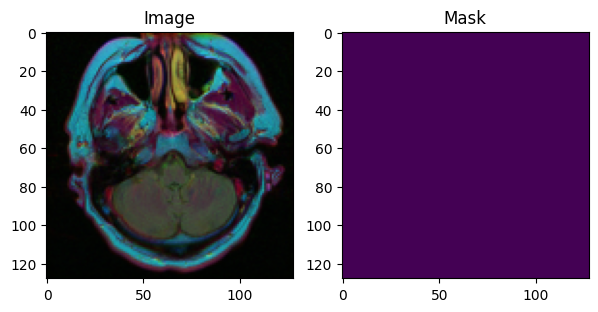

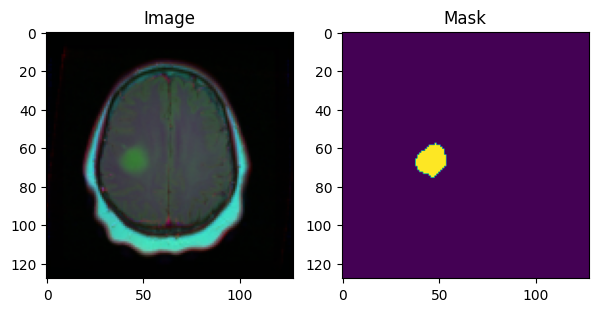

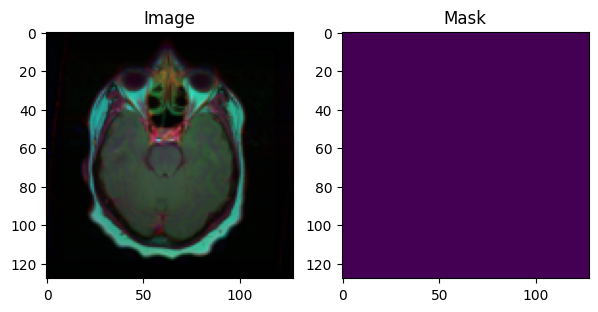

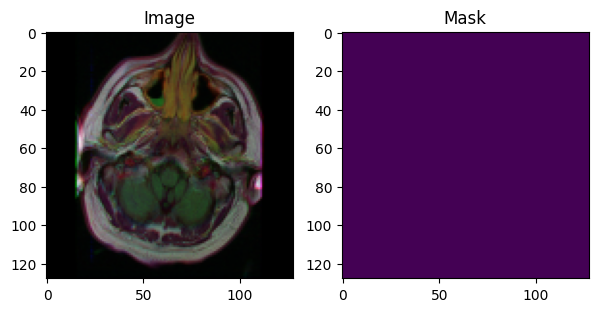

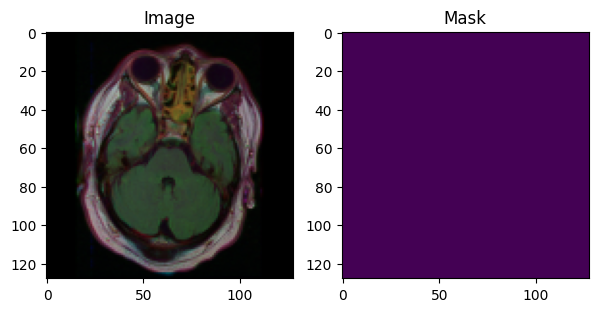

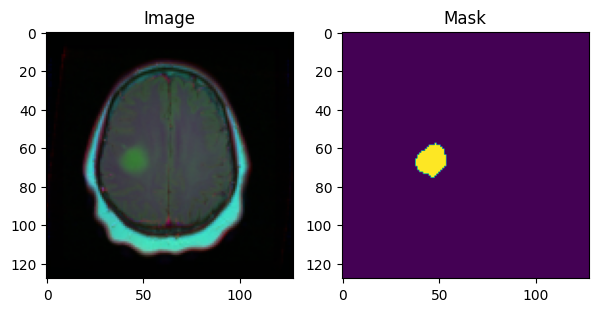

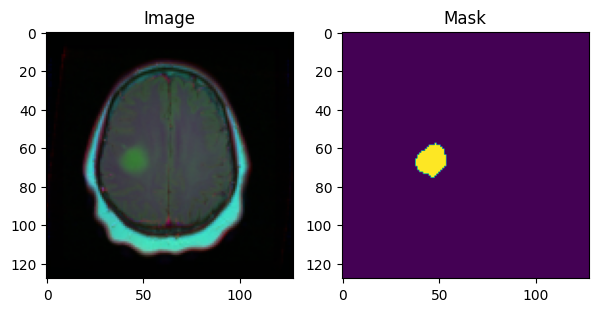

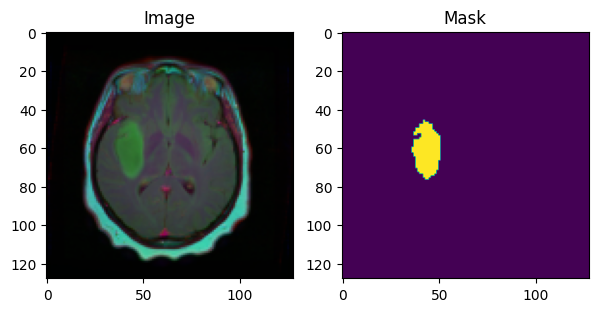

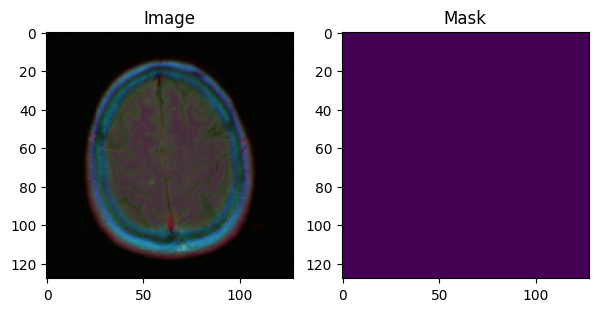

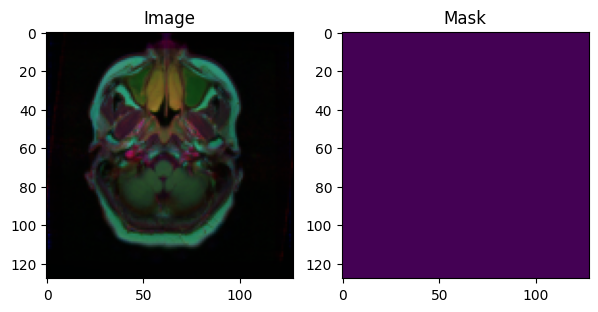

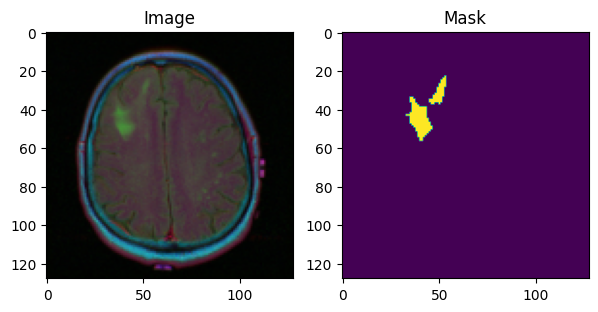

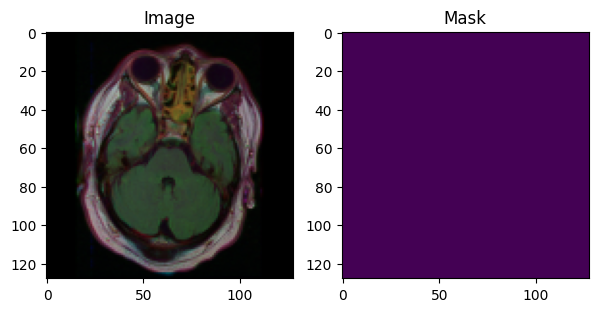

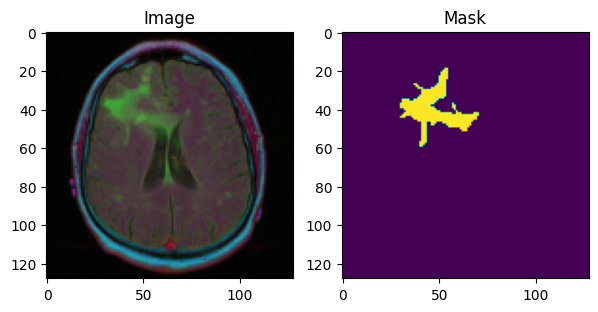

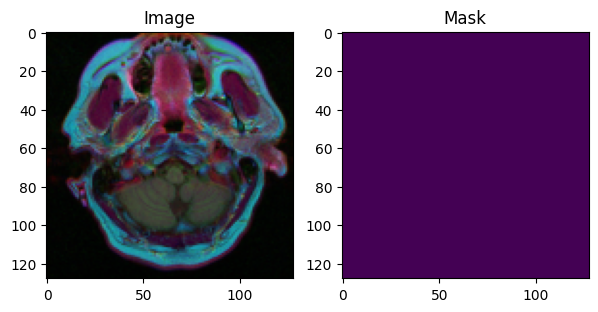

In [ ]:
l = [random.randint(0,50) for _ in range(20)]

for i in l:
    plot_image(images[i], masks[i])

In [ ]:
instance = []
for i in range(masks.shape[0]):

    if sum(sum(masks[i])) == 0:
        instance.append('neg')
    else:
        instance.append('pos')

In [ ]:
count = 0
for i in range(len(instance)):
    if instance[i] == 'pos':
        count += 1
print('Número de casos positivos: ', count)

count = 0
for i in range(len(instance)):
    if instance[i] == 'neg':
        count += 1
print('Número de casos negativos: ', count)

Número de casos positivos:  141
Número de casos negativos:  223


In [ ]:
n = images.shape[0]

images_pos = []
masks_pos = []

for i in range(n):
    if instance[i] == 'pos':
        images_pos.append(images[i])
        masks_pos.append(masks[i])

images_pos = np.array(images_pos)
masks_pos = np.array(masks_pos)

print('Número de imágenes ',images_pos.shape)
print('Número de mascaras ',masks_pos.shape)


Número de imágenes  (141, 128, 128, 3)
Número de mascaras  (141, 128, 128, 1)


### Spliting training and Test Images

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images_pos, masks_pos, test_size = .5, random_state = 32)

In [ ]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = .50, random_state = 288)

In [ ]:
print('#'*10 + ' Images ' + '#'*10)
print('X_train shape: ',  X_train.shape)
print('X_val shape:   ',  X_val.shape)
print('X_test shape:  ',  X_test.shape)
print('\n')
print('#'*10 + ' Masks ' + '#'*10)
print('y_train shape: ',  y_train.shape)
print('y_val shape:   ',  y_val.shape)
print('y_test shape:  ',  y_test.shape)

########## Images ##########
X_train shape:  (70, 128, 128, 3)
X_val shape:    (36, 128, 128, 3)
X_test shape:   (35, 128, 128, 3)


########## Masks ##########
y_train shape:  (70, 128, 128, 1)
y_val shape:    (36, 128, 128, 1)
y_test shape:   (35, 128, 128, 1)


## Step 3. Creating Model: UNet Model

##  Model 1: UNet Model

In [ ]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

# Encode module
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.1) (c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.1) (c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

# Decoder module
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.1) (c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)
outputs = Conv2D(1, 1, activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
# Summary of model created
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 16)   │            448 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 16)   │          2,320 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 16)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 32)     │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 32)     │          9,248 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 16, 16, 128)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 128)    │        147,584 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 128)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 8, 8, 256)      │        295,168 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 8, 8, 256)      │              0 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 8, 8, 256)      │        590,080 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose     

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

None


## Model-2: UNet

In [ ]:
# ### Creating convolutional block
# def create_conv_block(input_tensor, num_filters):
#     x = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(input_tensor)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Activation('relu')(x)
#     x = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Activation('relu')(x)
#     return x

# ### Creating  UNet Model
# def create_unet(input_shape, num_filters=16, dropout=0.1):
#     # Encoder module
#     c1 = create_conv_block(input_shape, num_filters * 1)
#     p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
#     p1 = tf.keras.layers.Dropout(dropout)(p1)

#     c2 = create_conv_block(p1, num_filters * 2)
#     p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
#     p2 = tf.keras.layers.Dropout(dropout)(p2)

#     c3 = create_conv_block(p2, num_filters * 4)
#     p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
#     p3 = tf.keras.layers.Dropout(dropout)(p3)

#     c4 = create_conv_block(p3, num_filters * 8)

#     # Decoder Module
#     u5 = tf.keras.layers.Convolution2DTranspose(num_filters*8, (3, 3), strides=(2, 2), padding='same')(c4)
#     u5 = tf.keras.layers.concatenate([u5, c3])
#     u5 = tf.keras.layers.Dropout(dropout)(u5)
#     c5 = create_conv_block(u5, num_filters*4)

#     u6 = tf.keras.layers.Convolution2DTranspose(num_filters*4, (3, 3), strides=(2, 2), padding='same')(c5)
#     u6 = tf.keras.layers.concatenate([u6, c2])
#     u6 = tf.keras.layers.Dropout(dropout)(u6)
#     c6 = create_conv_block(u6, num_filters*2)

#     u7 = tf.keras.layers.Convolution2DTranspose(num_filters*2, (3, 3), strides=(2, 2), padding='same')(c6)
#     u7 = tf.keras.layers.concatenate([u7, c1])
#     u7 = tf.keras.layers.Dropout(dropout)(u7)
#     c7 = create_conv_block(u7, num_filters*1)

#     output = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)
#     model = tf.keras.Model(inputs = [input_shape], outputs = [output])
#     return model
# ###  calling creating UNet model
# inputs = tf.keras.layers.Input((128, 128, 3))
# model = create_unet(inputs)
# model.summary()

In [ ]:
# def create_unet(input_shape, num_filters=16, dropout=0.1):
#     # Encoder

#     c1 = create_conv_block(input_shape, num_filters * 1)
#     p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
#     p1 = tf.keras.layers.Dropout(dropout)(p1)

#     c2 = create_conv_block(p1, num_filters * 2)
#     p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
#     p2 = tf.keras.layers.Dropout(dropout)(p2)

#     c3 = create_conv_block(p2, num_filters * 4)
#     p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
#     p3 = tf.keras.layers.Dropout(dropout)(p3)

#     c4 = create_conv_block(p3, num_filters * 8)

#     # Decoder

#     u5 = tf.keras.layers.Convolution2DTranspose(num_filters*8, (3, 3), strides=(2, 2), padding='same')(c4)
#     u5 = tf.keras.layers.concatenate([u5, c3])
#     u5 = tf.keras.layers.Dropout(dropout)(u5)
#     c5 = create_conv_block(u5, num_filters*4)

#     u6 = tf.keras.layers.Convolution2DTranspose(num_filters*4, (3, 3), strides=(2, 2), padding='same')(c5)
#     u6 = tf.keras.layers.concatenate([u6, c2])
#     u6 = tf.keras.layers.Dropout(dropout)(u6)
#     c6 = create_conv_block(u6, num_filters*2)

#     u7 = tf.keras.layers.Convolution2DTranspose(num_filters*2, (3, 3), strides=(2, 2), padding='same')(c6)
#     u7 = tf.keras.layers.concatenate([u7, c1])
#     u7 = tf.keras.layers.Dropout(dropout)(u7)
#     c7 = create_conv_block(u7, num_filters*1)

#     output = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)
#     model = tf.keras.Model(inputs = [input_shape], outputs = [output])

#     return model

In [ ]:
# inputs = tf.keras.layers.Input((128, 128, 3))
# model = create_unet(inputs)

## Step 4. Compiling and Training  model

### 4.1. Compiling model: Model parameter setting and selection of loss function

The optimizer used here is Adam with a learning rate of 0.001 and the loss function is 'categorical crossentropy'

In [ ]:
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

###  4.2. Training of model:

The model  will be trained for 10 epochs with a batch size 4. The best weight, with maximum validation accuracy is saving as h5 file. Early stopping is included such that if the validation accuracy is not increasing for consecutive 8 epochs (patience=8), then the training will be stopped. ReduceLROnPlateau is used for optimizing the learning rate by monitoring the validation accuracy. If the validation accuracy is not increasing for consecutive 5 epochs, then the learning rate will reduce to half of current learning rate.

In [ ]:
history_1 = model.fit(X_train,
                          y_train,
                          verbose = 1,
                          epochs = 100,
                          validation_data = (X_val, y_val))
model.save("/content/drive/MyDrive/Brain_Tumor/UNet_BrainTumor.h5")

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 38s 7s/step - accuracy: 0.2440 - loss: 0.7135 - val_accuracy: 0.7864 - val_loss: 0.6869
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - accuracy: 0.8104 - loss: 0.6838 - val_accuracy: 0.8662 - val_loss: 0.6550
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.8902 - loss: 0.6382 - val_accuracy: 0.9564 - val_loss: 0.3294
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9622 - loss: 0.4318 - val_accuracy: 0.9681 - val_loss: 0.2964
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9709 - loss: 0.3246 - val_accuracy: 0.9688 - val_loss: 0.3980
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9723 - loss: 0.3616 - val_accuracy: 0.9687 - val_loss: 0.2949
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9750 - loss: 0.2829 - val_accuracy: 0.9688 - val_loss: 0.2361
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9721 - loss: 0.2432 - val_accuracy: 0.9688 - val_loss:

In [ ]:
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_acc' , mode='max' ,
#                                                   factor = 0.5 , patience = 5 , verbose=1 , cooldown = 1,
#                                                  min_delta = 0.0001)

# early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=8, verbose=1,
#                                               mode = 'max', restore_best_weights = True)
# check_path = 'H:/CAMUS Dataset/unet.h5'
# checkpoint = tf.keras.callbacks.ModelCheckpoint(check_path, monitor = 'val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')


# history_1 = model.fit(data_train, mask_train, validation_data=(data_test,mask_test), epochs=10,
#                       batch_size=4, callbacks = [reduce_lr, early_stop, checkpoint] )

## Step 5. Visualization of training loss and accuracy

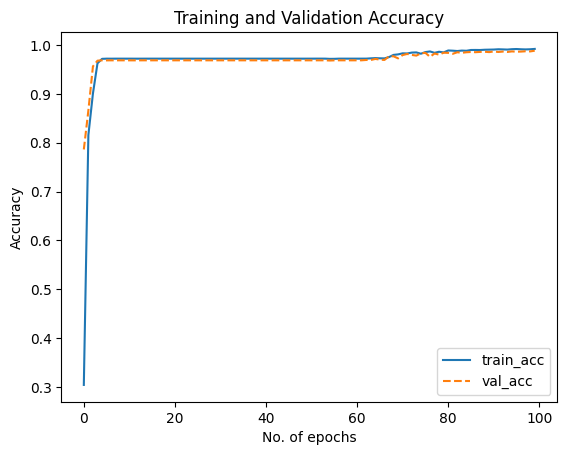

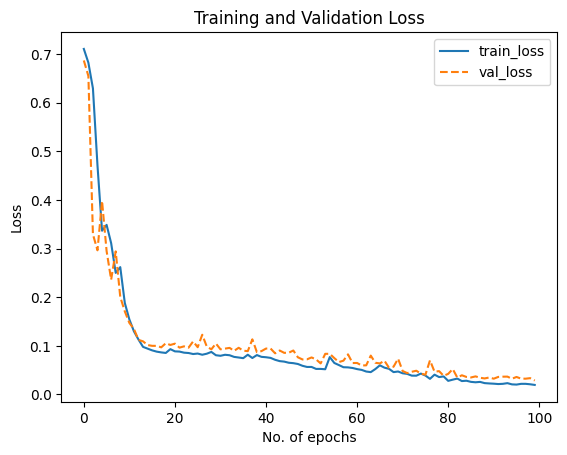

In [ ]:
plt.plot(history_1.history['accuracy'] , label = 'train_acc')
plt.plot(history_1.history['val_accuracy'] ,'--', label = 'val_acc')
plt.legend()
plt.xlabel("No. of epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.show()

plt.plot(history_1.history['loss'] , label = 'train_loss')
plt.plot(history_1.history['val_loss'] ,'--', label = 'val_loss')
plt.legend()
plt.xlabel("No. of epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.show()

## Step 6. Model prediction

In [ ]:
# loading the saved weight to the model
model.load_weights("/content/drive/MyDrive/Brain_Tumor/UNet_BrainTumor.h5")

In [ ]:
# y_pred = model.predict(test_images)

ValueError: Unrecognized data type: x=/content/drive/MyDrive/new/TCGA_CS_4941_19960909_11.tif (of type <class 'str'>)

In [ ]:
# plt.imshow(y_pred[5,:,:].reshape(128, 128),cmap='gray')
# plt.axis('off')
# plt.title("Predicted")

Text(0.5, 1.0, 'Predicted')

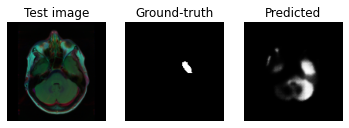

In [ ]:
pred = np.reshape(y_pred,(172,128,128))

fig=plt.figure()
fig.figsize=(30,30)

ax=fig.add_subplot(1,3,1)
plt.imshow(test_images[0, :, :])
plt.axis('off')
plt.title("Test image")

ax=fig.add_subplot(1,3,2)
plt.imshow(y_test[0,:,:].reshape(128, 128),cmap='gray')
plt.axis('off')
plt.title("Ground-truth")

ax=fig.add_subplot(1,3,3)
plt.imshow(pred[0],cmap='gray')
plt.axis('off')
plt.title("Predicted")

Text(0.5, 1.0, 'Predicted')

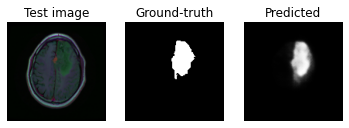

In [ ]:
pred = np.reshape(y_pred,(172,128,128))

fig=plt.figure()
fig.figsize=(30,30)

ax=fig.add_subplot(1,3,1)
plt.imshow(test_images[1, :, :])
plt.axis('off')
plt.title("Test image")

ax=fig.add_subplot(1,3,2)
plt.imshow(y_test[1,:,:].reshape(128, 128),cmap='gray')
plt.axis('off')
plt.title("Ground-truth")

ax=fig.add_subplot(1,3,3)
plt.imshow(pred[1],cmap='gray')
plt.axis('off')
plt.title("Predicted")

# Step 7. Evaluation of performance of the model

### 7.1. Average quality metrics
The performance of the model is evaluated by using the metrics Mean IoU, Accuracy, Precision, Recall and Dice coefficient.

In [ ]:
from sklearn.metrics import classification_report
import tensorflow.keras.backend as K
def dice_coef(y_test, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice
dice=dice_coef(y_test, y_pred)
print(dice)



tf.Tensor(0.56264275, shape=(), dtype=float32)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
Segmentation mask saved as 'predicted_mask.png'


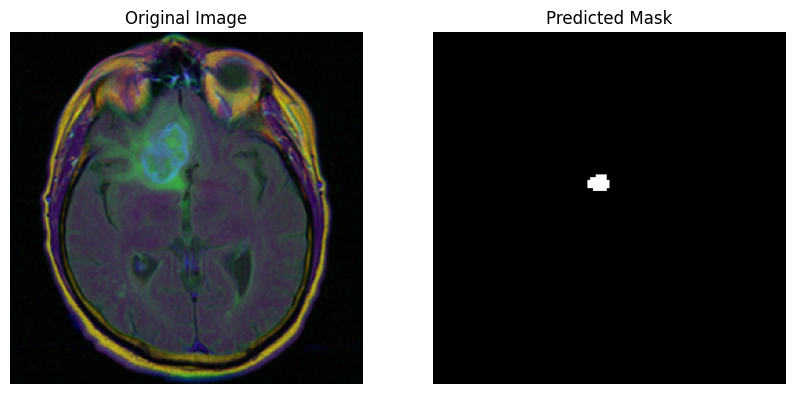

In [ ]:
import numpy as np
import tensorflow as tf
from PIL import Image
import cv2

# Load your trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/Brain_Tumor/UNet_BrainTumor.h5')  # Replace with your model's path

# Load and preprocess the .tif image to match the model's input shape
def load_and_preprocess_image(image_path, target_size=(128, 128)):
    # Load the .tif image
    image = Image.open(image_path)
    # Convert the image to RGB if it is grayscale or RGBA
    image = image.convert("RGB")
    # Resize to match model input shape (128, 128, 3)
    image = image.resize(target_size)
    # Convert to numpy array and normalize pixel values
    image = np.array(image) / 255.0
    # Add batch dimension for model input (1, 128, 128, 3)
    image = np.expand_dims(image, axis=0)
    return image

# Path to the test image
image_path = '/content/drive/MyDrive/new/TCGA_CS_4941_19960909_12.tif'  # Replace with the actual path to your .tif file

# Preprocess the image
input_image = load_and_preprocess_image(image_path)

# Predict segmentation mask
predicted_mask = model.predict(input_image)[0]  # Remove batch dimension

# Post-process the predicted mask if needed (e.g., thresholding)
predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # Assuming binary mask

# Save or display the output mask
cv2.imwrite('predicted_mask.png', predicted_mask * 255)  # Save as binary image
print("Segmentation mask saved as 'predicted_mask.png'")
original_image = Image.open(image_path).convert("RGB")
predicted_mask_resized = cv2.resize(predicted_mask, original_image.size, interpolation=cv2.INTER_NEAREST)

# Display the original image and predicted mask side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask_resized, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.show()